# Project 4 / Logistic Regression and Indeed.com


### Description

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal thinks the best way to gauge salary amounts is to take a look at what industry factors influence the pay scale for these professionals.
Aggregators like Indeed.com regularly pool job postings from a variety of markets and industries. Your job is to understand what factors most directly impact data science salaries and effectively, accurately find appropriate data science related jobs in your metro region.

### Project Summary

In this project, we are going to collect salary information on data science jobs in a variety of markets. Then using the location, title, and summary of the job, we will attempt to predict a corresponding salary for that job. While most listings DO NOT come with salary information (as you will see in this exercise), being able extrapolate or predict the expected salaries for other listings will be extremely useful for negotiations

### Project Objectives

1. Inspect data from Indeed.com on data science salary trends for your analysis.

2. Select and parse data from at least 1000 postings for jobs, potentially from multiple location searches.

3. Find out what factors most directly impact salaries (Title, location, department, etc.). In this case, we do  not want to predict mean salary as would be done in a regression. Your boss believes that salary is better represented in categories than continuously

4. Test, validate, and describe your models. What factors predict salary category? How do your models perform?

5. Author a report to your Principal detailing your analysis.


## Step 1: Load the Packages and Data¶


In [1]:
import re
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
%matplotlib inline

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, KFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold

/Users/ginodefalco/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
file_loc = "/Users/ginodefalco/dsi/dsi-workspace/projects/project_4_Indeed Salary Predictions/data/indeed-scraped-job-postings.csv"

df = pd.read_csv(file_loc)
df.head()

,city,company,salary,summary,title,parsed_salary
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5
2,Denver,Mental Health Center of Denver,"$70,000 - $80,000 a year",Advise the Data Developer with regard to creat...,Financial Data Scientist,75000.0
3,Denver,Denver Public Schools,"$62,712 - $75,255 a year",Portal managers on student outcome data report...,SENIOR RESEARCH ANALYST,68983.5
4,Denver,University of Colorado,"$25,000 - $29,000 a year",Experience entering and manipulating data in a...,Animal Care I,27000.0


In [5]:
# There are some missing entries in the parsed_salary column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 6 columns):
city             413 non-null object
company          413 non-null object
salary           413 non-null object
summary          413 non-null object
title            413 non-null object
parsed_salary    406 non-null float64
dtypes: float64(1), object(5)
memory usage: 19.4+ KB


In [6]:
df.shape


(413, 6)

## Step 2: Clean the data


In [7]:
# Delete 'salary' and 'summary' column
del df['salary']
del df['summary']

# Rename 'parsed_salary' to 'average salary'
df.rename(columns=lambda x: x.replace('parsed_salary', 'average_salary'), inplace=True)

# Drop any NaNs. These values are from the hourly or contract-work jobs, which I will emit.
df.dropna(inplace=True)

In [8]:
# Find median salary
print df['average_salary'].median()

# Create 'high/low' column: high, 1; low, 0 for median salary $100,000
df['high_low'] = df['average_salary'].apply(lambda x: 1 if x > 100000 else 0)

100000.0


In [9]:
# Clean 'city' column
df['city'] = np.where(df['city'] == 'Palo+Alto', 'Palo_Alto', df['city'])
df['city'] = np.where(df['city'] == 'San+Diego', 'San_Diego', df['city'])
df['city'] = np.where(df['city'] == 'New+York', 'New_York', df['city'])
df['city'] = np.where(df['city'] == 'Los+Angeles', 'Los_Angeles', df['city'])
df['city'] = np.where(df['city'] == 'San+Francisco', 'San_Francisco', df['city'])

# Create 'state' column
df['state'] = df['city']
df['state'] = np.where(df['state'] == 'Denver', 'Colorado', df['state'])
df['state'] = np.where(df['state'] == 'Austin', 'Texas', df['state'])
df['state'] = np.where(df['state'] == 'Seattle', 'Washington', df['state'])
df['state'] = np.where(df['state'] == 'Philadelphia', 'Pennsylvania', df['state'])
df['state'] = np.where(df['state'] == 'Palo_Alto', 'California', df['state'])
df['state'] = np.where(df['state'] == 'Pittsburgh', 'Pennsylvania', df['state'])
df['state'] = np.where(df['state'] == 'Miami', 'Florida', df['state'])
df['state'] = np.where(df['state'] == 'Chicago', 'Illinois', df['state'])
df['state'] = np.where(df['state'] == 'Dallas', 'Texas', df['state'])
df['state'] = np.where(df['state'] == 'San_Diego', 'California', df['state'])
df['state'] = np.where(df['state'] == 'New_York', 'New_York', df['state'])
df['state'] = np.where(df['state'] == 'Boston', 'Massachusetts', df['state'])
df['state'] = np.where(df['state'] == 'Los_Angeles', 'California', df['state'])
df['state'] = np.where(df['state'] == 'Phoenix', 'Arizona', df['state'])
df['state'] = np.where(df['state'] == 'Houston', 'Texas', df['state'])
df['state'] = np.where(df['state'] == 'Portland', 'Oregon', df['state'])
df['state'] = np.where(df['state'] == 'San_Francisco', 'California', df['state'])
df['state'] = np.where(df['state'] == 'Atlanta', 'Georgia', df['state'])

### Clean the 'title' column

The 'title' column includes job positions like "Animal Care I" that are unrelated to data science. I will filter these rows out and drop them below.

In [10]:
df['title'].head()


0               Statistician, GS-1350-12 (DEU-PERM-DS)
1    Interdisciplinary Cartographer/Geographer - GS...
2                             Financial Data Scientist
3                              SENIOR RESEARCH ANALYST
4                                        Animal Care I
Name: title, dtype: object

In [11]:
# Clean 'title' column by removing punctuation and numbers and then lowercase
df['title'] = df['title'].replace('\d', '', regex=True)
df['title'] = df['title'].replace('[^0-9a-zA-Z ]', ' ', regex=True)
df['title'] = df['title'].str.lower()

**1. Filter out jobs unrelated to data science**

In [12]:
clean_title = []

for row in df['title']:  
    
    # keywords associated with data science, data science roles
    if 'data' in row:
        clean_title.append(row)
    elif 'engineer' in row:
        clean_title.append(row)
    elif 'scientist' in row:
        clean_title.append(row)
    elif 'analyst' in row:
        clean_title.append(row)
    elif 'statistician' in row:
        clean_title.append(row)
    elif 'machine learning' in row:
        clean_title.append(row)
    elif 'nlp' in row:
        clean_title.append(row)
    elif 'director' in row:
        clean_title.append(row)
    elif 'statistical' in row:
        clean_title.append(row)
        
    # if not data science related, print "Not a data science job"    
    else:
        clean_title.append("Not a data science job")

df['clean_title'] = clean_title

**2. Count how many jobs are unrelated to data science**

In [13]:
pd.value_counts(df['clean_title'].values, sort=True).head()


Not a data science job     74
data scientist             23
senior data scientist      12
senior research analyst     6
lead data scientist         6
dtype: int64

**3. Delete the rows with "Not a data science job"**


In [14]:
df = df[df.clean_title != 'Not a data science job']
df.shape

(332, 7)

**I created the new column, 'clean_title', after skimming the data and selecting the keywords that most related to data science. I feel that the keywords I chose encompassed most of the data science jobs, but in the future I will have to be more selective of the data before re-doing this project.
Using .value_counts(), I saw that I filtered out 76 rows that included jobs that were not related to data science, so I dropped them.**

**4. Consolidate 'title' and 'clean_title'**


In [15]:
df['title'] = df['clean_title']
df.drop('clean_title', axis=1, inplace=True)
df.head()

,city,company,title,average_salary,high_low,state
0,Denver,Department Of The Interior,statistician gs deu perm ds,87792.0,0,Colorado
2,Denver,Mental Health Center of Denver,financial data scientist,75000.0,0,Colorado
3,Denver,Denver Public Schools,senior research analyst,68983.5,0,Colorado
5,Denver,Denver Health,assistant research scientist radars,93645.0,0,Colorado
6,Denver,Denver Health,statistical research specialist,66654.0,0,Colorado


### Create Dummy Variables


#### 5. Create dummy variables for 'title'

**I'm going to create dummy variables from the 'title' column to include seniority of position in the logisitic regression:**
- senior position, 'job_sen'
- management, 'job_mgmt'

**Note:** I am not creating a dummy variable for entry-level jobs. Just glancing over data, I had a hard time distinguishing which jobs may be entry level or which may be a senior-level position. For example, a 'senior data analyst' would show up as an entry-level and senior-level position based on the filters I have set-up.


In [16]:
# Create dummy variable for senior positions
df['job_senior'] = False
df.job_senior = df['title'].str.contains('senior|sr|scientist|statistician|engineer|developer')

# Fix 'NaN' which results when the title is a 'Nan'
df.job_senior.fillna(value = False, inplace = True)
df.job_senior = df.job_senior.astype(int)

# Create dummy variable for management positions
df['job_mgmt'] = False
df.job_mgmt = df['title'].str.contains('chief|director|manager|president')

# Fix 'NaN' which results when the title is a 'Nan'
df.job_mgmt.fillna(value = False, inplace = True)
df.job_mgmt = df.job_mgmt.astype(int)

**6. Create dummy variables for 'city'**


In [17]:
loc = ['city', 'state']

# For loop that will create dummy variables out of the categorical variables
for var in loc:
   cat_list = 'var' + '_' + var
   cat_list = pd.get_dummies(df[var], prefix=var)
   df1=df.join(cat_list)
   df=df1


**Final dataframe**


In [18]:
df.head()


,city,company,title,average_salary,high_low,state,job_senior,job_mgmt,city_Atlanta,city_Austin,...,state_Colorado,state_Florida,state_Georgia,state_Illinois,state_Massachusetts,state_New_York,state_Oregon,state_Pennsylvania,state_Texas,state_Washington
0,Denver,Department Of The Interior,statistician gs deu perm ds,87792.0,0,Colorado,1,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Denver,Mental Health Center of Denver,financial data scientist,75000.0,0,Colorado,1,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Denver,Denver Public Schools,senior research analyst,68983.5,0,Colorado,1,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Denver,Denver Health,assistant research scientist radars,93645.0,0,Colorado,1,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,Denver,Denver Health,statistical research specialist,66654.0,0,Colorado,0,0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df.columns


Index([u'city', u'company', u'title', u'average_salary', u'high_low', u'state',
       u'job_senior', u'job_mgmt', u'city_Atlanta', u'city_Austin',
       u'city_Boston', u'city_Chicago', u'city_Dallas', u'city_Denver',
       u'city_Houston', u'city_Los_Angeles', u'city_Miami', u'city_New_York',
       u'city_Palo_Alto', u'city_Philadelphia', u'city_Phoenix',
       u'city_Pittsburgh', u'city_Portland', u'city_San_Diego',
       u'city_San_Francisco', u'city_Seattle', u'state_Arizona',
       u'state_California', u'state_Colorado', u'state_Florida',
       u'state_Georgia', u'state_Illinois', u'state_Massachusetts',
       u'state_New_York', u'state_Oregon', u'state_Pennsylvania',
       u'state_Texas', u'state_Washington'],
      dtype='object')

### Step 3: Exploratory Data Analysis¶


#### Baseline Accuracy

The Baseline Accuracy is the accuracy that can be achieved by a model simply by guessing the majority class every time.

**baseline_accuracy = majority_class_N / total_population**

In [20]:
base_acc = 1 - np.mean(df['high_low'])
print base_acc

0.448795180723


#### Salary by Location Pivot Table


In [21]:
loc_salary = pd.pivot_table(df, index=['state', 'city'],
                              values = ['average_salary',
                                        'high_low'],
                              aggfunc=np.mean,
                              margins = True)

loc_salary

average_salary  high_low
state         city                                   
Arizona       Phoenix          75542.166667  0.000000
California    Los_Angeles     114402.305556  0.500000
              Palo_Alto       123761.895833  0.791667
              San_Diego        90709.785714  0.428571
              San_Francisco   148138.214286  0.857143
Colorado      Denver           90722.850000  0.300000
Florida       Miami            85575.000000  0.200000
Georgia       Atlanta          93482.000000  0.250000
Illinois      Chicago         119837.318182  0.575758
Massachusetts Boston          114227.076923  0.666667
New_York      New_York        112713.114458  0.481928
Oregon        Portland         78195.500000  0.000000
Pennsylvania  Philadelphia    105545.454545  0.636364
              Pittsburgh       41474.400000  0.000000
Texas         Austin          105833.333333  0.500000
              Dallas           91863.636364  0.272727
              Houston          63226.100000  0.000000
Washington    Seattle         130659.846154  0.769231
All                           113901.188253  0.551205

**Note: If the value of the 'high/low' column is above 0.50 then the average salary is deemed "high", and below 0.50 the average salary is deemed "low".**

### Visualization

**Crosstab View of High/Low Salaries by City**

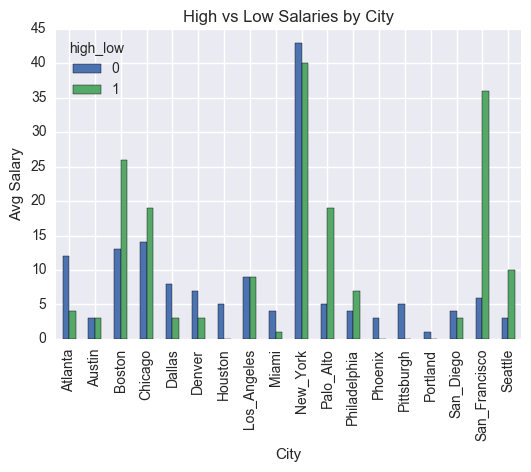

In [22]:
pd.crosstab(df['city'], df['high_low']).plot(kind='bar')
plt.title('High vs Low Salaries by City')
plt.xlabel('City')
plt.ylabel('Avg Salary')

#### Top 10 Cities by Average Salary


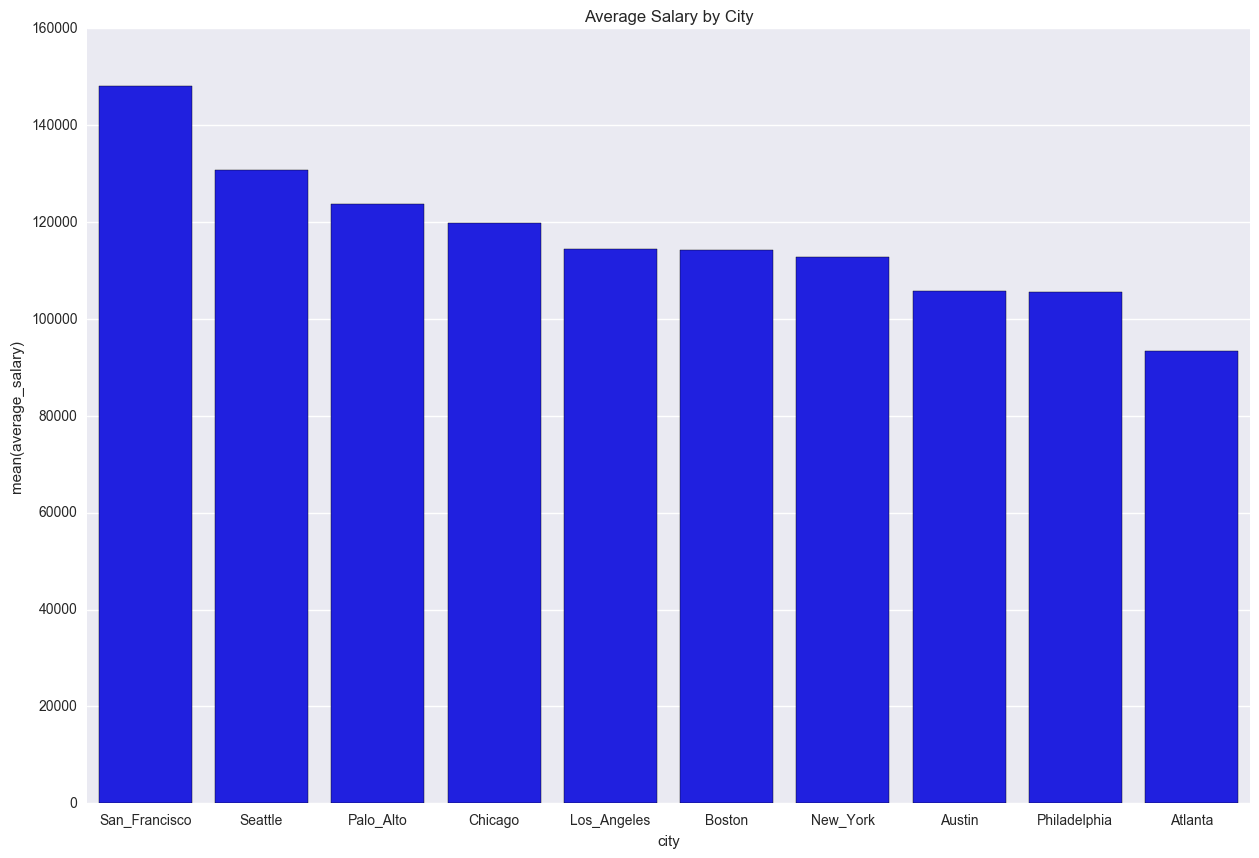

In [23]:
# create the dataframe that groups 'city' with 'average salary'
loc_salary = df.groupby("city", as_index=False)["average_salary"].mean()

# get the top 10 cities
loc_salary = loc_salary.sort_values("average_salary", ascending=False).head(10)

# plot the barplot
plt.figure(figsize=(15,10))
sns.barplot(x=loc_salary["city"], y=loc_salary['average_salary'],color='b').set(title='Average Salary by City')

1. San Francisco, CA
2. Seattle, WA
3. Palo Alto, CA
4. Chicago, Illinois
5. Los Angeles, CA
6. Boston, MA
7. New York, NY
8. Austin, TX
9. Philadelphia, PA
10. Atlanta, GA


## Step 4: Predicting Salaries with Logistic Regression

**A. Predict 'high_low' salary by 'city' using statsmodels**

In [24]:
model = sm.logit("high_low ~ city", data=df).fit()
model.summary()

         Current function value: 0.584348
         Iterations: 35


/Users/ginodefalco/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_low   No. Observations:                  332
Model:                          Logit   Df Residuals:                      314
Method:                           MLE   Df Model:                           17
Date:                Wed, 06 Sep 2017   Pseudo R-squ.:                  0.1505
Time:                        16:21:03   Log-Likelihood:                -194.00
converged:                      False   LL-Null:                       -228.38
                                        LLR p-value:                 3.530e-08
=========================================================================================
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                -1.0986      0.577     -1.903      0.057        -2.230     0.033
city[T.Austin]            1.0986      1.000      1.099      0.272        -0.861     3.059
city[T.Boston]            1.7918      0.670      2.675      0.007         0.479     3.105
city[T.Chicago]           1.4040      0.676      2.076      0.038         0.078     2.730
city[T.Dallas]            0.1178      0.890      0.132      0.895        -1.626     1.862
city[T.Denver]            0.2513      0.900      0.279      0.780        -1.512     2.015
city[T.Houston]         -22.5369   6.07e+04     -0.000      1.000     -1.19e+05  1.19e+05
city[T.Los_Angeles]       1.0986      0.745      1.474      0.140        -0.362     2.559
city[T.Miami]            -0.2877      1.258     -0.229      0.819        -2.754     2.179
city[T.New_York]          1.0263      0.618      1.661      0.097        -0.184     2.237
city[T.Palo_Alto]         2.4336      0.765      3.179      0.001         0.933     3.934
city[T.Philadelphia]      1.6582      0.852      1.946      0.052        -0.012     3.328
city[T.Phoenix]         -74.2159   1.31e+16  -5.68e-15      1.000     -2.56e+16  2.56e+16
city[T.Pittsburgh]      -22.5369   6.07e+04     -0.000      1.000     -1.19e+05  1.19e+05
city[T.Portland]        -11.5770    565.544     -0.020      0.984     -1120.023  1096.869
city[T.San_Diego]         0.8109      0.957      0.847      0.397        -1.066     2.687
city[T.San_Francisco]     2.8904      0.726      3.979      0.000         1.466     4.314
city[T.Seattle]           2.3026      0.876      2.630      0.009         0.586     4.019
=========================================================================================
"""

** Most notable cities with a high P-value include:**
- San Francisco, CA (0.000)
- Palo Alto, CA (0.001)
- Boston, MA (0.007)
- Seattle, WA (0.009)
- Chicago, IL (0.038)

### B. Logistic regression using statsmodels with more features


In [25]:
# Adding in 'job_senior' and 'job_mgmt'
model = sm.logit("high_low ~ city + job_senior + job_mgmt", data=df).fit()
model.summary()

         Current function value: 0.535017
         Iterations: 35


/Users/ginodefalco/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_low   No. Observations:                  332
Model:                          Logit   Df Residuals:                      312
Method:                           MLE   Df Model:                           19
Date:                Wed, 06 Sep 2017   Pseudo R-squ.:                  0.2222
Time:                        16:22:19   Log-Likelihood:                -177.63
converged:                      False   LL-Null:                       -228.38
                                        LLR p-value:                 2.850e-13
=========================================================================================
                            coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                -2.1612      0.650     -3.327      0.001        -3.434    -0.888
city[T.Austin]            1.1074      1.061      1.044      0.296        -0.972     3.186
city[T.Boston]            1.5220      0.704      2.161      0.031         0.141     2.903
city[T.Chicago]           1.1641      0.713      1.632      0.103        -0.234     2.562
city[T.Dallas]           -0.0567      0.927     -0.061      0.951        -1.873     1.759
city[T.Denver]           -0.1808      0.928     -0.195      0.846        -2.000     1.639
city[T.Houston]         -25.5428   1.45e+05     -0.000      1.000     -2.84e+05  2.84e+05
city[T.Los_Angeles]       1.1730      0.791      1.482      0.138        -0.378     2.724
city[T.Miami]            -0.3204      1.306     -0.245      0.806        -2.880     2.239
city[T.New_York]          0.9011      0.652      1.383      0.167        -0.376     2.178
city[T.Palo_Alto]         2.1954      0.801      2.742      0.006         0.626     3.765
city[T.Philadelphia]      1.3221      0.887      1.491      0.136        -0.416     3.060
city[T.Phoenix]         -56.1677   1.79e+12  -3.14e-11      1.000     -3.51e+12  3.51e+12
city[T.Pittsburgh]      -17.8147   6182.649     -0.003      0.998     -1.21e+04  1.21e+04
city[T.Portland]        -12.3553    655.223     -0.019      0.985     -1296.569  1271.858
city[T.San_Diego]         0.9362      1.018      0.919      0.358        -1.060     2.932
city[T.San_Francisco]     2.8009      0.763      3.673      0.000         1.306     4.295
city[T.Seattle]           1.9735      0.910      2.170      0.030         0.191     3.756
job_senior                1.5465      0.312      4.962      0.000         0.936     2.157
job_mgmt                  2.0372      0.598      3.406      0.001         0.865     3.210
=========================================================================================
"""

** Most notable P-values include:**
- 'job_senior' (0.000)
- San Francisco, CA (0.000)
- 'job_mgmt' (0.001)
- Palo Alto, CA (0.006)
- Seattle, WA (0.03)

### C. Logistic Regression in Sci-Kit Learn

** Data Preprocessing **


In [26]:
# Filter out categories
cat_vars=['city', 'state', 'company', 'title']
df_vars = df.columns.values.tolist()
to_keep=[i for i in df_vars if i not in cat_vars]

In [27]:
# Additional features
df_final=df[to_keep]
df_final.columns

Index([u'average_salary', u'high_low', u'job_senior', u'job_mgmt',
       u'city_Atlanta', u'city_Austin', u'city_Boston', u'city_Chicago',
       u'city_Dallas', u'city_Denver', u'city_Houston', u'city_Los_Angeles',
       u'city_Miami', u'city_New_York', u'city_Palo_Alto',
       u'city_Philadelphia', u'city_Phoenix', u'city_Pittsburgh',
       u'city_Portland', u'city_San_Diego', u'city_San_Francisco',
       u'city_Seattle', u'state_Arizona', u'state_California',
       u'state_Colorado', u'state_Florida', u'state_Georgia',
       u'state_Illinois', u'state_Massachusetts', u'state_New_York',
       u'state_Oregon', u'state_Pennsylvania', u'state_Texas',
       u'state_Washington'],
      dtype='object')

In [28]:
df_final.shape


(332, 34)

In [29]:
# # Target variable and feature variables
y = df_final['high_low']
X = df_final.drop(['high_low', 'average_salary'], axis=1)

In [30]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0,test_size = 0.30)

### Feature Ranking with Recursive Feature Elimination (RFE)

Recursive feature elimination is based on the idea of repeatedly constructing a model (SVM or regression) and choose either the best or worst performing feature (example: based on coefficients), setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. Features are then ranked according to when they were eliminated. As such, it is a greedy optimization for finding the best performing subset of features.

In [31]:
lr = LogisticRegression()

# Rank the features
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X_train, y_train)

print "Features sorted by their rank:", sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), df_final))

Features sorted by their rank: [(1.0, 'city_Portland'), (2.0, 'average_salary'), (3.0, 'high_low'), (4.0, 'city_Dallas'), (5.0, 'state_Arizona'), (6.0, 'city_San_Francisco'), (7.0, 'city_Seattle'), (8.0, 'job_mgmt'), (9.0, 'city_Houston'), (10.0, 'state_Colorado'), (11.0, 'city_Palo_Alto'), (12.0, 'state_Oregon'), (13.0, 'city_Chicago'), (14.0, 'city_Phoenix'), (15.0, 'city_Pittsburgh'), (16.0, 'city_San_Diego'), (17.0, 'city_Denver'), (18.0, 'city_New_York'), (19.0, 'city_Atlanta'), (20.0, 'state_Massachusetts'), (21.0, 'state_California'), (22.0, 'city_Austin'), (23.0, 'state_Pennsylvania'), (24.0, 'city_Miami'), (25.0, 'job_senior'), (26.0, 'state_Georgia'), (27.0, 'city_Philadelphia'), (28.0, 'city_Boston'), (29.0, 'city_Los_Angeles'), (30.0, 'state_Florida'), (31.0, 'state_New_York'), (32.0, 'state_Illinois')]


### Recursive Feature Elimination with Cross Validation


In [32]:
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")

# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2), scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

Optimal number of features : 32


### Grid Search using Logistic Regression


In [33]:
num_of_Features = np.linspace(1,32,32)


In [34]:
# Optimal set of features
parameters = {'n_features_to_select': num_of_Features}

# Setup Grid Search
gridsearch_logit_rfe = GridSearchCV(rfe, parameters)
gridsearch_logit_rfe.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RFE(estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_features_to_select': array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
print "Train Score:", gridsearch_logit_rfe.score(X_train,y_train)
print "Test Score:", gridsearch_logit_rfe.score(X_test,y_test)

Train Score: 0.659482758621
Test Score: 0.69


** With a train score of about 66% accuracy and a test score with 69% accuracy, I am satisfied with the scores based on the small data set. This validates that this approach will do better than the baseline accuracy**


### Model Validation

In [36]:
from sklearn.metrics import confusion_matrix


In [37]:
y_pred = gridsearch_logit_rfe.predict(X_test)
confusion = confusion_matrix(y_test,y_pred)

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Plot the Confusion Matrix

This model makse a "True" good job prediction about 38% of the time and a "False" good job prediction 62% of the time. Also the model makes a "False" bad job prediction 11% of the time and a "True" bad job prediction 88% of the time. I think these results are acceptable. Ideally, we would want the model to find a higher "True" good job prediction, but we will have to settle with the model highlighting all the "True" bad jobs on Indeed.com. Since this is binary classifier, our accuracy would expect to be a 50%. This model predicts good versus bad jobs significantly better, despite the small data set.

Normalized confusion matrix
[[ 0.38461538  0.61538462]
 [ 0.1147541   0.8852459 ]]


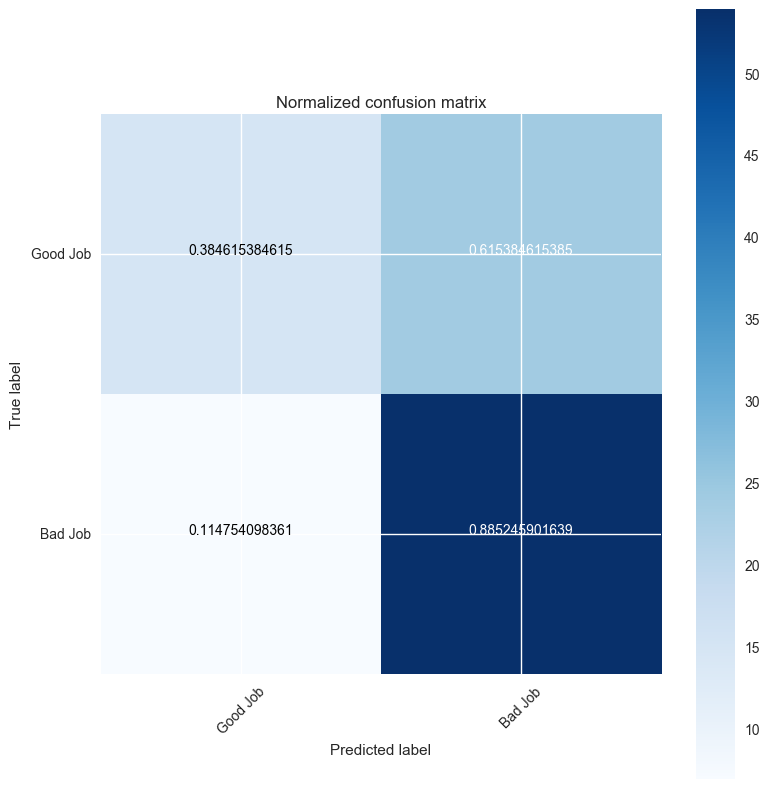

In [39]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion, classes=['Good Job','Bad Job'], normalize=True,
                      title='Normalized confusion matrix')

### Plot the ROC Curve

The ROC Curve is a plot of the true positive rate against the false positive rate for different possible cutoffs. It is a graphical representation that illustrates the performance of a binary classifier system as its discrimination threshold is varied. The true-positive rate is also known as the sensitivity, recall or probability of detection. The false-positive rate is also known as the probability of a false alarm.
The ROC Curve shown below demonstrates that the Area Under the Curve is about 63%, which is greater than our baseline accuracy of 50%. This means that overall, this model predicts an outcome better than a simple coin-flip.

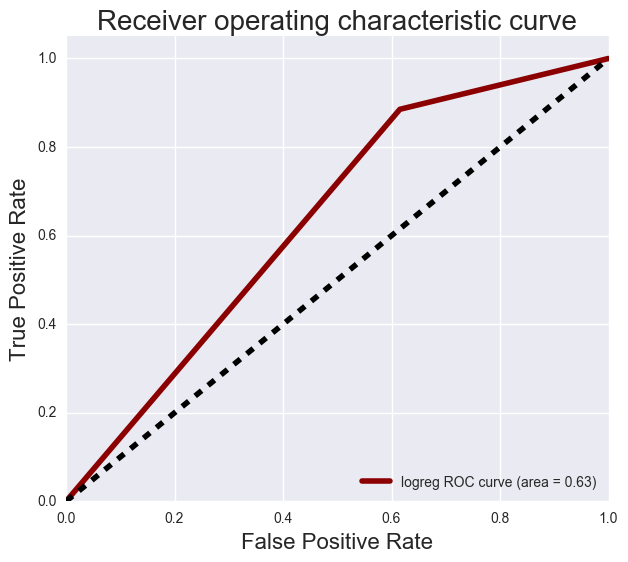

In [40]:
from sklearn.metrics import roc_curve, auc

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=[7,6])
plt.plot(fpr_lr, tpr_lr, label='logreg ROC curve (area = %0.2f)' % roc_auc_lr, 
         linewidth=4, color='darkred')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic curve', fontsize=20)
plt.legend(loc="lower right")
plt.show()